In [1]:
#!git clone https://github.com/whyhardt/SPICE.git

In [2]:
# !pip install -e SPICE

In [3]:
import pandas as pd
import numpy as np
from typing import Dict, List, Tuple
import matplotlib.pyplot as plt

from spice.estimator import SpiceEstimator
from spice.resources.spice_utils import SpiceConfig
from spice.utils.convert_dataset import convert_dataset
from spice.resources.rnn import BaseRNN
from spice.precoded import InteractionRNN, INTERACTION_CONFIG, ChoiceRNN, CHOICE_CONFIG, RescorlaWagnerRNN, RESCORLA_WAGNER_CONFIG

# For custom RNN
import torch
import torch.nn as nn

Let's load the data first with the `convert_dataset` method. This method returns a `SpiceDataset` object which we can use right away 

In [4]:
# Load your data
path_dataset = '../data/data_synthetic_v0.csv'

dataset = convert_dataset(
    file = path_dataset,
    df_participant_id='session',
    df_choice='choice',
    df_reward='reward',
    )

# structure of dataset:
# dataset has two main attributes: xs -> inputs; ys -> targets (next action)
# shape: (n_participants*n_blocks*n_experiments, n_timesteps, features)
# features are (n_actions * action, n_actions * reward, n_additional_inputs * additional_input, block_number, experiment_id, participant_id)

# in order to set up the participant embedding we have to compute the number of unique participants in our data 
# to get the number of participants n_participants we do:
n_participants = len(dataset.xs[..., -1].unique())

print(f"Shape of dataset: {dataset.xs.shape}")
print(f"Number of participants: {n_participants}")
n_actions = dataset.ys.shape[-1]
print(f"Number of actions in dataset: {n_actions}")
print(f"Number of additional inputs: {dataset.xs.shape[-1]-2*n_actions-3}")

Shape of dataset: torch.Size([256, 100, 7])
Number of participants: 256
Number of actions in dataset: 2
Number of additional inputs: 0


Now we are going to define the configuration for SPICE with a `SpiceConfig` object.

The `SpiceConfig` takes as arguments 
1. `library_setup (dict)`: Defining the variable names of each module.
2. `memory_state (dict)`: Defining the memory state variables and their initial values.
3. `states_in_logit (list)`: Defining which of the memory state variables are used later for the logit computation. This is necessary for some background processes.  

Let's setup now the `SpiceEstimator` object and fit it to the data!

In [5]:
path_model = '../params/spice_synthetic.pkl'

estimator = SpiceEstimator(
        # model paramaeters
        rnn_class=RescorlaWagnerRNN,
        spice_config=RESCORLA_WAGNER_CONFIG,
        n_actions=2,
        n_participants=n_participants,
        n_experiments=1,
        
        # rnn training parameters
        epochs=1000,
        l2_weight_decay=0.01,
        
        # sindy fitting parameters
        sindy_epochs=1000,
        sindy_threshold=0.1,
        sindy_threshold_frequency=100,
        sindy_weight=0.,#1,
        sindy_library_polynomial_degree=2,
        
        # other parameters
        verbose=True,
        save_path_spice=path_model,
    )

print(f"\nStarting training on {estimator.device}...")
print("=" * 80)
estimator.fit(dataset.xs, dataset.ys)
# estimator.load_spice(path_model)
print("=" * 80)
print("\nTraining complete!")

# Print example SPICE model for first participant
print("\nExample SPICE model (participant 0):")
print("-" * 80)
estimator.print_spice_model(participant_id=0)
print("-" * 80)


Starting training on cpu...

Training the RNN...
Epoch 1000/1000 --- L(Train): 0.7941534; Time: 0.04s; Convergence: 3.38e-08
Maximum number of training epochs reached.
Model did not converge yet.
RNN training finished.
Training took 56.31 seconds.
Saving SPICE model to ../params/spice_synthetic.pkl...

Training complete!

Example SPICE model (participant 0):
--------------------------------------------------------------------------------
value_reward_chosen[t+1] = -0.0021 1 + -0.0012 value_reward_chosen[t] 
--------------------------------------------------------------------------------


Let's inspect the cognitive dynamics and choice behavior in a plot and compare them to the ground-truth model

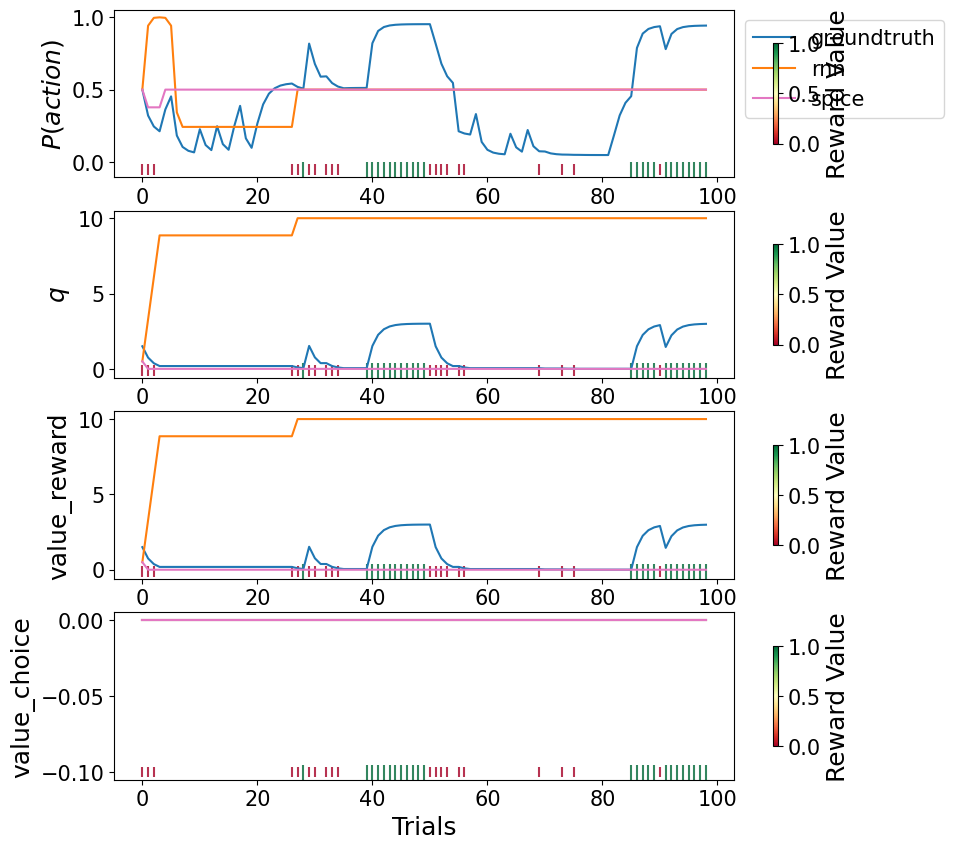

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

from spice.utils.plotting import plot_session
from spice.resources.bandits import AgentQ

dataset_df = pd.read_csv(path_dataset)

# get the parameters for the selected participant and set up the ground truth model
n_trials = 100
participant_id = 0
dataset_df = dataset_df[dataset_df['session'] == participant_id]

groundtruth = AgentQ(
    n_actions=2,
    beta_reward=dataset_df['beta_reward'][participant_id * n_trials],
    alpha_reward=dataset_df['alpha_reward'][participant_id * n_trials],
    alpha_penalty=dataset_df['alpha_penalty'][participant_id * n_trials],
    forget_rate=dataset_df['forget_rate'][participant_id * n_trials],
    beta_choice=dataset_df['beta_choice'][participant_id * n_trials],
    alpha_choice=dataset_df['alpha_choice'][participant_id * n_trials],
)

fig, axs = plot_session(
    agents={
        'groundtruth': groundtruth,
        'rnn': estimator.rnn_agent,
        'spice': estimator.spice_agent,
        },
    experiment=dataset.xs[participant_id]
    )

plt.show()